## 결정트리

In [734]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

mpl.style.use('seaborn')
mpl.rcParams["font.family"] = 'Malgun Gothic'
mpl.rcParams["axes.unicode_minus"] = False

In [735]:
import time
def my_time(func):
    def wrapper():
        str_time = time.time()
        func()
        end_time = time.time()
        print(end_time-str_time, '초 소요')
    return wrapper

In [736]:
X = pd.read_csv('../data/aug_train.csv')
X_test = pd.read_csv('../data/aug_test.csv')

In [737]:
X.shape, X.columns

((19158, 14),
 Index(['enrollee_id', 'city', 'city_development_index', 'gender',
        'relevent_experience', 'enrolled_university', 'education_level',
        'major_discipline', 'experience', 'company_size', 'company_type',
        'last_new_job', 'training_hours', 'target'],
       dtype='object'))

In [738]:
y = X['target']
X.drop(columns=['enrollee_id','target'],inplace=True)

In [739]:
toplotlist = list(X.isna().sum().sort_values(ascending=False).index)
toplotlist

['company_type',
 'company_size',
 'gender',
 'major_discipline',
 'education_level',
 'last_new_job',
 'enrolled_university',
 'experience',
 'city',
 'city_development_index',
 'relevent_experience',
 'training_hours']

In [740]:
num_plot_lst = ['city_development_index','training_hours']
for i in num_plot_lst:
    toplotlist.remove(i)
obj_plot_lst = toplotlist

In [741]:
len(obj_plot_lst)

10

In [742]:
obj_plot_lst

['company_type',
 'company_size',
 'gender',
 'major_discipline',
 'education_level',
 'last_new_job',
 'enrolled_university',
 'experience',
 'city',
 'relevent_experience']

# Rawdata 시각화 

In [743]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 1.8+ MB


In [744]:
X.isna().sum().sort_values(ascending=False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
dtype: int64

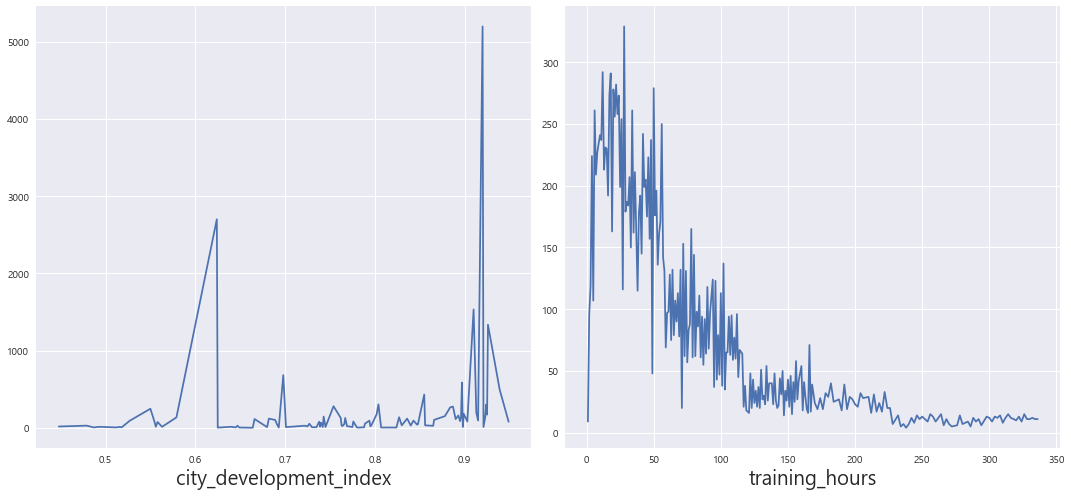

In [745]:
fig, axes = plt.subplots(nrows=1, ncols=len(num_plot_lst), figsize=(15,7))

for idx,i in enumerate(num_plot_lst):
    X[i].value_counts().sort_index().plot(ax=axes[idx])
    axes[idx].set_xlabel(i, fontsize=20)
    
plt.tight_layout()
plt.show()

In [746]:
# @my_time
# def vis():
#     n = 2 # 열 수
#     fig, axes = plt.subplots(nrows=(len(obj_plot_lst)+1)//2, ncols=n, figsize=(15,30))
#     for idx, i in enumerate(obj_plot_lst):
#         sns.countplot(x=i, hue='target', data=X, ax=axes[idx//n, idx%n])
#         axes[idx//n, idx%n].set_xlabel(i, fontsize=20)
#         axes[idx//n, idx%n].legend(['이직미희망', '이직희망'],
#                                    bbox_to_anchor=(1,1), loc='upper right', fontsize=12)
#     plt.tight_layout()
#     plt.show()
    
# vis()

In [747]:
# # city는 따로 확인
# plt.figure(figsize=(10,50))
# X.groupby(['city','target']).count().plot(kind='barh')
# # sns.countplot(x='city', hue='target', data=X)
# plt.plot(kind='barh', )
# plt.legend(['이직미희망', '이직희망'],
#                            bbox_to_anchor=(1,1), loc='upper right', fontsize=12)
# plt.show()

In [748]:
X['city'].value_counts().sort_values(ascending=False)

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_111       3
city_121       3
city_129       3
city_171       1
city_140       1
Name: city, Length: 123, dtype: int64

# 전처리

#### 해당 컬럼부터 숫자형으로 변경

In [749]:
numeric_feature = ['city_development_index', 'training_hours',
                   'education_level', 'last_new_job',  'experience', 'enrolled_university']

In [750]:
# 각 컬럼 데이터 개수부터 확인
for col in numeric_feature:
    print(X[col].unique().size)
    print(X[col].unique())

93
[0.92  0.776 0.624 0.789 0.767 0.764 0.762 0.913 0.926 0.827 0.843 0.804
 0.855 0.887 0.91  0.884 0.924 0.666 0.558 0.923 0.794 0.754 0.939 0.55
 0.865 0.698 0.893 0.796 0.866 0.682 0.802 0.579 0.878 0.897 0.949 0.925
 0.896 0.836 0.693 0.769 0.775 0.903 0.555 0.727 0.64  0.516 0.743 0.899
 0.915 0.689 0.895 0.89  0.847 0.527 0.766 0.738 0.647 0.795 0.74  0.701
 0.493 0.84  0.691 0.735 0.742 0.479 0.722 0.921 0.848 0.856 0.898 0.83
 0.73  0.68  0.725 0.556 0.448 0.763 0.745 0.645 0.788 0.78  0.512 0.739
 0.563 0.518 0.824 0.487 0.649 0.781 0.625 0.807 0.664]
241
[ 36  47  83  52   8  24  18  46 123  32 108  23  26 106   7 132  68  50
  48  65  13  22 148  72  40 141  82 145 206 152  42  14 112  87  20  21
  92 102  43  45  19  90  25  15  98 142  28 228  29  12  17  35   4 136
  27  74  86  75 332 140 182 172  33  34 150 160   3   2 210 101  59 260
 131 109  70  51  60 164 290 133  76 156 120 100  39  55  49   6 125 326
 198  11  41 114 246  81  31  84 105  38 178 104 202  88 218  6

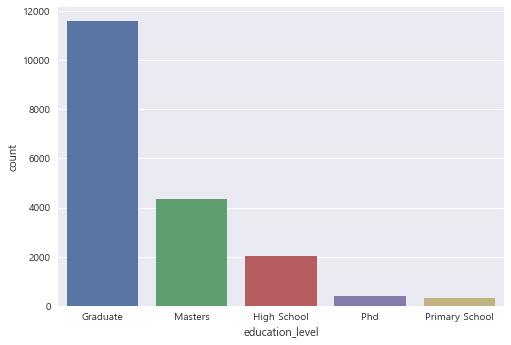

460


In [751]:
sns.countplot(x='education_level', data=X)
plt.show()
print(X['education_level'].isna().sum())

#### edu_lvl

In [752]:
education_level = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
for i, v in enumerate(education_level):
    X.loc[X['education_level']==v, 'education_level'] = i

In [753]:
X['education_level'].value_counts(dropna=False)

2.0    11598
3.0     4361
1.0     2017
NaN      460
4.0      414
0.0      308
Name: education_level, dtype: int64

#### last_new_job

In [754]:
X.loc[X['last_new_job'] == '>4', 'last_new_job'] = 5
X.loc[X['last_new_job'] == 'never', 'last_new_job'] = 0

X['last_new_job'] = pd.to_numeric(X['last_new_job'], downcast='integer')

In [755]:
X['last_new_job'].value_counts()

1.0    8040
5.0    3290
2.0    2900
0.0    2452
4.0    1029
3.0    1024
Name: last_new_job, dtype: int64

#### exp

In [756]:
X.loc[X['experience'] == '>20', 'experience'] = 21
X.loc[X['experience'] == '<1', 'experience'] = 0

X['experience'] = pd.to_numeric(X['experience'], downcast='integer')

In [757]:
X['experience'].value_counts(dropna=False)

21.0    3286
5.0     1430
4.0     1403
3.0     1354
6.0     1216
2.0     1127
7.0     1028
10.0     985
9.0      980
8.0      802
15.0     686
11.0     664
14.0     586
1.0      549
0.0      522
16.0     508
12.0     494
13.0     399
17.0     342
19.0     304
18.0     280
20.0     148
NaN       65
Name: experience, dtype: int64

#### enroll

In [758]:
enrolls = ['no_enrollment','Part time course','Full time course']
for i,v in enumerate(enrolls):
    X.loc[X['enrolled_university'] == v, 'enrolled_university'] = i

In [759]:
X['enrolled_university'].value_counts(dropna=False)

0.0    13817
2.0     3757
1.0     1198
NaN      386
Name: enrolled_university, dtype: int64

In [760]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  float64
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  float64
 11  training_hours          19158 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


In [761]:
X.isna().sum().sort_values(ascending=False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
dtype: int64

#### 결측치 3% 이하 컬럼의 결측치는 KNN으로 처리

In [762]:
to_mode = ['education_level', 'enrolled_university',
           'experience', 'last_new_job']

In [763]:
limit = X.shape[0] * 0.03
under_list = []
for col in X.columns:
    if 1 < X[col].isna().sum() < limit:
        under_list.append(col)
under_list

['enrolled_university', 'education_level', 'experience', 'last_new_job']

In [764]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 1)
X[under_list] = imputer.fit_transform(X[under_list])

In [765]:
# 최빈값으로 결측치 처리
# for col in to_mode:
#     X.loc[X[col].isna(),col] = X[col].mode().values[0]   

#### gender: nan->위에서부터 반: Male / 나머지 반: Female

In [766]:
gender_nan_cnt = X['gender'].isna().sum()//2
# 내 방법
# idx = 0
# for idx in range(X.shape[0]):
#     if gender_nan_cnt <= 0:
#         break
#     if X.loc[idx,'gender'] == np.nan:
#         X.loc[idx,'gender'] = 'Male'
#         gender_nan_cnt -= 1
# X.loc[X['gender'].isna(), 'gender'] = 'Female'

# 우상님 방법
X['gender'].fillna('Female', limit=gender_nan_cnt, inplace=True)
X['gender'].fillna('Male', inplace=True)

#### company_size, type

In [767]:
X.loc[X['company_size'].isna(), 'company_size'] = 'unknown'
X.loc[X['company_size']=='<10', 'company_size'] = '~10'
X.loc[X['company_type'].isna(), 'company_type'] = 'unknown'

#### major: 비율 맞춰 major nomajor로 나눠 결측치 처리x
#### -> 최빈값과 나머지의 합과의 비율 차이가 크므로 최빈값 major로 처리

In [768]:
# # 비율맞춰 처리
# stem = X['major_discipline'].value_counts(dropna=False)['STEM']
# nonstem = X.shape[0] - X['major_discipline'].isna().sum() - stem
# stem, nonstem

In [769]:
# non_major_list = []
# for val in X['major_discipline'].unique():
#     if val != 'STEM':
#         non_major_list.append(val)
        
# non_major = X['major_discipline'].isin(non_major_list)
# major = X['major_discipline'] == 'STEM'

# X.loc[non_major, 'major_discipline'] = 'non_major'
# X.loc[major, 'major_discipline'] = 'major'

In [770]:
nomajor_lst = list(X['major_discipline'].value_counts(dropna=False).index)
nomajor_lst.remove(np.nan)
nomajor_lst.remove('STEM')
print(nomajor_lst)

['Humanities', 'Other', 'Business Degree', 'Arts', 'No Major']


In [771]:
# X.loc[X['major_discipline'] == 'STEM', 'major_discipline'] = 'major'
# X.loc[X['major_discipline'].isin(nomajor_lst), 'major_discipline'] = 'no_major'

In [772]:
# major_limit = int(X['major_discipline'].isna().sum() / (stem+nonstem) * stem)
# X['major_discipline'].fillna('major', limit=major_limit, inplace=True)
# X['major_discipline'].fillna('no_major', inplace=True)

In [773]:
X.loc[(X['major_discipline'] == 'STEM')|(X['major_discipline'].isna()) , 'major_discipline'] = 'major'
X.loc[X['major_discipline'] != 'major', 'major_discipline'] = 'no_major'

In [774]:
X['major_discipline'].value_counts()

major       17305
no_major     1853
Name: major_discipline, dtype: int64

In [775]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     19158 non-null  float64
 5   education_level         19158 non-null  float64
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  float64
 8   company_size            19158 non-null  object 
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  float64
 11  training_hours          19158 non-null  int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 1.8+ MB


#### 라벨 인코딩

In [776]:
X['city'] = LabelEncoder().fit_transform(X['city'])

#### 원핫인코딩

In [777]:
X['company_size'].unique()

array(['unknown', '50-99', '~10', '10000+', '5000-9999', '1000-4999',
       '10/49', '100-500', '500-999'], dtype=object)

In [778]:
to_ohe = list(X.columns[X[X.columns].dtypes == 'object'])
to_ohe

['gender',
 'relevent_experience',
 'major_discipline',
 'company_size',
 'company_type']

In [779]:
# 원핫 인코딩x 컬럼들
X_not_ohe = X.loc[:,~X.columns.isin(to_ohe)]
X_not_ohe.shape, X_not_enc.columns

((19158, 7),
 Index(['enrollee_id', 'city', 'city_development_index', 'enrolled_university',
        'education_level', 'experience', 'last_new_job', 'training_hours',
        'target'],
       dtype='object'))

In [780]:
# 원핫 인코딩 컬럼들
X_ohe = X[to_ohe]
X_ohe

,gender,relevent_experience,major_discipline,company_size,company_type
0,Male,Has relevent experience,major,unknown,unknown
1,Male,No relevent experience,major,50-99,Pvt Ltd
2,Female,No relevent experience,major,unknown,unknown
3,Female,No relevent experience,no_major,unknown,Pvt Ltd
4,Male,Has relevent experience,major,50-99,Funded Startup
...,...,...,...,...,...
19153,Male,No relevent experience,no_major,unknown,unknown
19154,Male,Has relevent experience,major,unknown,unknown
19155,Male,Has relevent experience,major,50-99,Pvt Ltd
19156,Male,Has relevent experience,major,500-999,Pvt Ltd


In [781]:
# 원핫인코딩 실행
ohe = OneHotEncoder(sparse=False)
X_df = ohe.fit_transform(X_ohe)
X_ohe = pd.DataFrame(X_df, columns=ohe.get_feature_names())
X_ohe.shape, X_ohe.columns

((19158, 23),
 Index(['x0_Female', 'x0_Male', 'x0_Other', 'x1_Has relevent experience',
        'x1_No relevent experience', 'x2_major', 'x2_no_major', 'x3_10/49',
        'x3_100-500', 'x3_1000-4999', 'x3_10000+', 'x3_50-99', 'x3_500-999',
        'x3_5000-9999', 'x3_unknown', 'x3_~10', 'x4_Early Stage Startup',
        'x4_Funded Startup', 'x4_NGO', 'x4_Other', 'x4_Public Sector',
        'x4_Pvt Ltd', 'x4_unknown'],
       dtype='object'))

In [782]:
# 합치기
X_new = pd.concat([X_ohe, X_not_ohe], axis=1)
X_new

,x0_Female,x0_Male,x0_Other,x1_Has relevent experience,x1_No relevent experience,x2_major,x2_no_major,x3_10/49,x3_100-500,x3_1000-4999,...,x4_Public Sector,x4_Pvt Ltd,x4_unknown,city,city_development_index,enrolled_university,education_level,experience,last_new_job,training_hours
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,5,0.920,0.0,2.0,21.0,1.0,36
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,77,0.776,0.0,2.0,15.0,5.0,47
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,64,0.624,2.0,2.0,5.0,0.0,83
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,14,0.789,2.0,2.0,0.0,0.0,52
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,50,0.767,0.0,3.0,21.0,4.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,55,0.878,0.0,2.0,14.0,1.0,42
19154,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,5,0.920,0.0,2.0,14.0,4.0,52
19155,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,5,0.920,0.0,2.0,21.0,4.0,44
19156,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,94,0.802,0.0,1.0,0.0,2.0,97


In [783]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   x0_Female                   19158 non-null  float64
 1   x0_Male                     19158 non-null  float64
 2   x0_Other                    19158 non-null  float64
 3   x1_Has relevent experience  19158 non-null  float64
 4   x1_No relevent experience   19158 non-null  float64
 5   x2_major                    19158 non-null  float64
 6   x2_no_major                 19158 non-null  float64
 7   x3_10/49                    19158 non-null  float64
 8   x3_100-500                  19158 non-null  float64
 9   x3_1000-4999                19158 non-null  float64
 10  x3_10000+                   19158 non-null  float64
 11  x3_50-99                    19158 non-null  float64
 12  x3_500-999                  19158 non-null  float64
 13  x3_5000-9999                191

#### 테이블 저장

In [784]:
X_new.shape

(19158, 30)

In [785]:
X_new.to_csv('../data/prepcd_train.csv', index=False)

### 행 내 결측치 개수 별 drop행수

In [488]:
# drop_index = {}

# for j in range(X.shape[1]):
#     cnt_to_del = 0
#     for i in X.index:
#         if X.loc[i].isna().sum() >= j:
#             cnt_to_del += 1
# #             drop_index.append(i)
#     drop_index[j] = cnt_to_del

# print(len(drop_index))

KeyboardInterrupt: 

In [ ]:
drop_index

In [ ]:
def nul_churi(df, H_P_0=4, H_P_1=500, H_P_2='mode'):
    df_new = df.copy()
    how_to_left = ['mode','max','mean','median']
    class InvalidModeError(Exception):
        def __init__(self, invalid_mode):
            self.invalid_mode = invalid_mode
        def __str__(self):
            return f"{self.invalid_mode} - 사용할 수 없는 모드입니다. 입력값 확인!"
        
    if type(H_P_0) != int and type(H_P_1) != int and H_P_2 not in how_to_left:
        raise InvalidModeError(mode)
        
#     drop_list = []
#     for col in df_new.columns:
#         if 1 <= df_new[col].isna().sum() <= H_P_0:
#             drop_list.append(col)
#     print(drop_list)
#     df_new.dropna(subset=drop_list, inplace=True)
    # 한 행 결측치 개수 기준
    drop_index = []
    for i in df_new.index:
        if df_new.loc[i].isna().sum() >= H_P_0:
            df_new.drop(index=i, inplace=True)
    
#     for col in df_new.columns:
#         if 1 <= df_new[col].isna().sum() <= H_P_1:
#             if H_P_1=='mode':
#                 df_new.loc[df_new[col].isna(), col] = df_new[col].mode()[0]
#             elif H_P_1=='max':
#                 df_new.loc[df_new[col].isna(), col] = df_new[col].max()[0]
#             elif H_P_1=='mean':
#                 df_new.loc[df_new[col].isna(), col] = df_new[col].mean()[0]
#             elif H_P_1=='median':
#                 df_new.loc[df_new[col].isna(), col] = df_new[col].median()[0]
                
    return df_new

In [ ]:
@my_time
def a():
    X_train = nul_churi(X,4,500,'mode')
    
a()

In [ ]:
for i in ['city_development_index']:#,'training_hours']:
    X_train[i].value_counts().sort_index().plot()

In [ ]:
X_train.info()

In [ ]:
# 모든 처리 끝낸 후 데이터 분리
X_train, y_train = X_train.drop(columns=['enrollee_id','target']), X_train['target']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 트레인/테스트 범주형 컬럼 전체 다 레이블인코딩
def enco(x):
    if x.dtypes=='object':
        le = LabelEncoder()
        xx = le.fit_transform(x)
        return xx
    else:
        return x

X_train = X_train.apply(enco)
X_test = X_test.apply(enco)
X_train.head()

In [ ]:
X_train.head()

In [ ]:
params = {
    'max_depth':range(2,20),
    'min_samples_leaf':range(100,1000,200),
    'max_leaf_nodes':range(5,50,10)
}

tree = DecisionTreeClassifier(random_state=1)
gs = GridSearchCV(tree,
                 param_grid=params,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1
                 )

In [ ]:
@my_time
def detree_train():
    gs.fit(X_train, y_train)
    
detree_train()

In [ ]:
df = pd.DataFrame(gs.cv_results_)
df.sort_values("rank_test_score")

In [ ]:
fi = gs.best_estimator_.feature_importances_
fi_s = pd.Series(fi, index=X_train.columns)
fi_s.sort_values(ascending=False)